In [1]:
import MDAnalysis as mda
import nglview as nv
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
u = mda.Universe(
    "data/ox-tail-10_1.tpr",  # topology file -- atom information etc
    "data/ox-tail-10_1_skip100.xtc",  # trajectory file -- coordinates
)

In [3]:
n_frames = len(u.trajectory)
print(f"This trajectory has {n_frames} frames")

This trajectory has 17 frames


In [4]:
print(len(u.atoms))

289012


In [5]:
print(len(u.residues))

88121


In [6]:
u.residues.resnames

array(['CHOL', 'CHOL', 'CHOL', ..., 'ION', 'ION', 'ION'], dtype=object)

In [7]:
membrane_residues = u.select_atoms("not resname ION PW")
n_membrane_residues = membrane_residues.n_residues
print(n_membrane_residues)

4032


In [8]:
# nv.show_mdanalysis(membrane_residues)

Make sure we select at least one headgroup bead per lipid, probably ignoring cholesterols though.

In [9]:
headgroups = membrane_residues.select_atoms(
    "name PO4 GL1 GL2 AM1 AM2 NC3 GM* C3"
)
assert "CHOL" not in headgroups.resnames
assert "CLRO" not in headgroups.resnames

In [10]:
n_chol = membrane_residues.select_atoms("resname CHOL CLRO").n_residues
assert n_chol + len(headgroups.residues) == n_membrane_residues

Let's assign tail saturation and headgroups here from residue names.

In [11]:
from lipyds.utils.guessing import guess_lipid_headgroup, guess_lipid_tail_saturation

In [12]:
guess_lipid_headgroup(membrane_residues)

In [13]:
guess_lipid_tail_saturation(membrane_residues)

In [14]:
membrane_residues.lipid_headgroups

array(['CHOL', 'CHOL', 'CHOL', ..., 'DAG', 'DAG', 'DAG'], dtype=object)

In [15]:
membrane_residues.lipid_tail_saturations

array(['Chol', 'Chol', 'Chol', ..., 'Mono', 'Mono', 'Mono'], dtype=object)

In [16]:
# nv.show_mdanalysis(headgroups)

## Leafletfinder

In [17]:
from lipyds.leafletfinder.leafletfinder import LeafletFinder

In [18]:
finder = LeafletFinder(
    universe=membrane_residues,
    select="name PO4 GL1 GL2 AM1 AM2 NC3 GM* C3",
    cutoff=30, # increase for higher accuracy but slower time
    pbc=True,
    method="spectralclustering",  # works for most bilayers
    n_leaflets=2,
    normal_axis="z",
    update_TopologyAttr=True
)

This cell is not necessary to run, but is good for pre-viewing leaflet assignments

In [19]:
# finder.run()

# # for visualisation in VMD
# u.add_TopologyAttr("tempfactors")
# membrane_residues.atoms.tempfactors = membrane_residues.leaflets
# membrane_residues.atoms.write("membrane.pdb")

This cell below with nglview freezes my Macbook M2, might work for others though

In [20]:
# view = nv.show_file("membrane.pdb")
# view.remove_ball_and_stick()
# view.add_ball_and_stick("all", color_scheme="bfactors")
# view

## Area per Lipid

In this algorithm, we select all headgroup points within `cutoff` around the headgroup of the residue we are looking at. The point normal of the central residue is used to define the plane to project points onto. The points are projected and a 2D Voronoi tessellation is computed (using scipy). The area of the polygon that the central residue is located within, is computed as the area per lipid.

**One area this may differ from others** is the use of the central residue point normal to define the plane. This can be a bit noisy and it may be much more robust to average the normals of all neighbours instead, as is done in the LipidTilt below.

**One idea that sounds good but doesn't work so well** is taking advantage of the triangular mesh. It *seems* like you should be able to take the center of all faces using the central residue vertex to create a new container polygon and compute the area of that. However, if I recall correctly, the APL just wound up having very extreme values. 

In [19]:
from lipyds import AreaPerLipid

In [20]:
apl_resnames = AreaPerLipid(
    universe=membrane_residues,
    select="name PO4 GL1 GL2 AM1 AM2 NC3 GM* C3",
    leafletfinder=finder,
    group_by_attr="resnames",
    update_leaflet_step=1,  # update every step -- increase if flip flop doesnt matter
    cutoff=30,  # cutoff to look for neighbors -- increase for accuracy but slower
)

In [21]:
apl_headgroups = AreaPerLipid(
    universe=membrane_residues,
    select="name PO4 GL1 GL2 AM1 AM2 NC3 GM* C3",
    leafletfinder=finder,
    group_by_attr="lipid_headgroups",
    update_leaflet_step=1,  # update every step -- increase if flip flop doesnt matter
    cutoff=30,  # cutoff to look for neighbors -- increase for accuracy but slower
)

In [22]:
apl_resnames.run(verbose=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [23]:
apl_headgroups.run(verbose=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [24]:
list(apl_headgroups.results.keys())

['areas_by_leaflet', 'areas', 'areas_by_attr']

In [25]:
df_resnames = apl_resnames.results_as_dataframe()
df_headgroups = apl_headgroups.results_as_dataframe()

In [26]:
df_resnames.head()

,Leaflet,Value,Time,Label,Property
0,1,71.765949,0.0,DBCE,areas
1,1,101.484627,1250000.0,DBCE,areas
2,1,62.633449,2500000.0,DBCE,areas
3,1,79.825678,3750000.0,DBCE,areas
4,1,47.786303,5000000.0,DBCE,areas


In [27]:
mean_apl = df_resnames[
    ["Leaflet", "Label", "Value", "Time"]
].groupby(["Leaflet", "Label"]).mean().reset_index()
mean_apl.head()

,Leaflet,Label,Value,Time
0,1,DBCE,66.547701,11031250.0
1,1,DBG1,66.530070,10000000.0
2,1,DBG3,69.843583,10000000.0
3,1,DBGS,68.461637,10000000.0
4,1,DOPC,88.607841,10000000.0


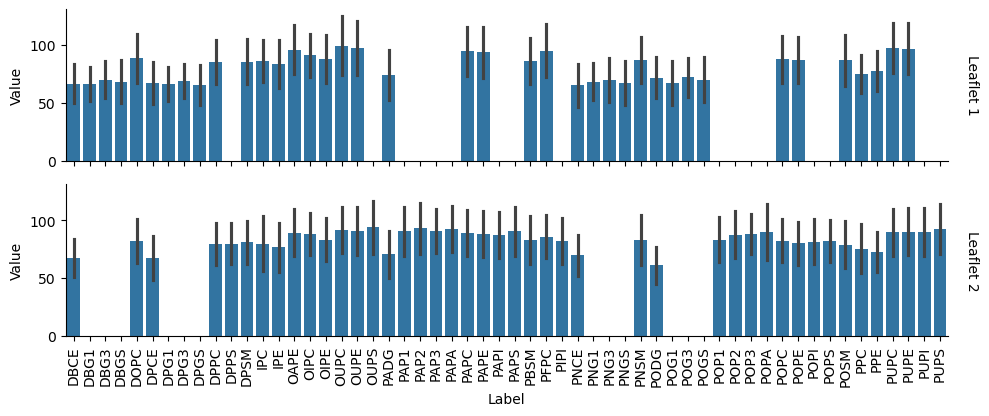

In [28]:
g = sns.catplot(
    data=df_resnames,  # note this is all observations, not the mean_apl
    kind="bar",
    row="Leaflet",
    x="Label",
    y="Value",
    aspect=5,
    height=2,
    margin_titles=True,
    errorbar="sd",  # "se" for standard error
)
g.tick_params('x', rotation=90)
g.set_titles(row_template="Leaflet {row_name}")

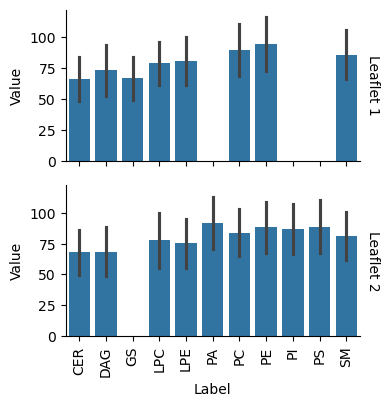

In [29]:
g = sns.catplot(
    data=df_headgroups,  # note this is all observations, not the mean_apl
    kind="bar",
    row="Leaflet",
    x="Label",
    y="Value",
    aspect=2,
    height=2,
    margin_titles=True,
    errorbar="sd",  # "se" for standard error
)
g.tick_params('x', rotation=90)
g.set_titles(row_template="Leaflet {row_name}")

## Membrane thickness

`MembraneThickness` subclasses `GriddedBilayerAnalysisBase`, so it has a few extra attributes. It calculates values over a 2D grid.

Primarily the extra arguments are:

* `grid_bounds`: this helps define the grid. In an NPT simulation the box can change, so to define a static grid for the analysis we need to figure out how to define the overall box. The accepted values are "max", "min", "mean", and the default is "max".
* `axes`: how to define the 2D grid (which axes to use). Default is ("x", "y").
* `bin_size`: how much area to cover with each cell. Default is 2 Å (so each cell covers a 2Å x 2Å area). Values too low can lead to noise in the average values.

In [30]:
from lipyds.analysis.thickness import MembraneThickness

In [31]:
thickness = MembraneThickness(
    universe=membrane_residues,
    select="name PO4 GL1 GL2 AM1 AM2 NC3 GM* C3",
    leafletfinder=finder,
    bin_size=4,  # each box covers 4x4 A
)

In [32]:
thickness.run(verbose=True)

  0%|          | 0/17 [00:00<?, ?it/s]

/Users/lily/pydev/lipyds/lipyds/analysis/thickness.py:67: RuntimeWarning: Mean of empty slice
  self.results.mean_interpolated = np.nanmean(self.results.interpolated_thicknesses, axis=1)
/Users/lily/micromamba/envs/lipyds-dev/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


For the mean/sd value per frame:

In [33]:
thickness.results.thickness_mean

array([[37.60388471, 37.45262211, 37.47199049, 37.44929847, 37.55908382,
        37.44491292, 37.62696974, 37.57328933, 37.80270959, 37.63210937,
        37.64366851, 37.2799205 , 37.39724762, 37.57269141, 37.40138018,
        37.53801522, 37.82782778]])

In [34]:
thickness.results.thickness_std

array([[3.44855008, 2.83319579, 3.05716377, 2.81222902, 3.69916783,
        2.90405955, 3.2276078 , 3.24498474, 3.61537183, 3.04068618,
        2.88298451, 3.05522553, 2.97134956, 3.14957615, 3.08101902,
        3.4689315 , 3.22026495]])

The raw thicknesses are present in `thickness.results.thicknesses`. This is a list of list of arrays. `thickness.results.thicknesses[i][j][k]` yields the ith bilayer, the jth frame, and the kth point (a linear array matching up total residues).

In [35]:
thickness.results.thicknesses[0][0].shape

(2233,)

In [36]:
len(thickness.results.thicknesses)

1

In [37]:
len(thickness.results.thicknesses[0][0])

2233

Part of subclassing `GriddedAnalysisBase` is you can access the axes of the grid, e.g.

In [38]:
thickness.x_axis

array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
        44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
        88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
       132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
       176., 180., 184., 188., 192., 196., 200., 204., 208., 212., 216.,
       220., 224., 228., 232., 236., 240., 244., 248., 252., 256., 260.,
       264., 268., 272., 276., 280., 284., 288., 292., 296., 300., 304.,
       308., 312.])

The code below should render the "middle" leaflet of the bilayer as a triangular mesh. It's an interactive plot and is a bit buggy on my Macbook M2 so hopefully it works.

The "middle" leaflet is composed of each residue point projected halfway along its normal, where "halfway" is "halfway to the interfacing with the other leaflet". That means the middle has *one point for each residue in both leaflets*.

The thickness is then computed from each residue in each leaflet to the middle. Doing this sets a "Thickness" array on the Pyvista surface, which we can take advantage of to plot below.

For each triangular mesh we augment the bilayer by crossing the periodic boundary and padding with additional points. We do this so the mesh is accurate for points and faces up to the periodic boundary. These are the faces in grey below.

I embedded a screenshot in case the interactive viewer isn't showing (it can be flaky for me).

<img src="screenshot.png">

In [41]:
thickness.bilayers[0].middle.surface.plot(scalars="Thickness")

Widget(value="<iframe src='http://localhost:52016/index.html?ui=P_0x159ea4910_0&reconnect=auto' style='width: …

Or to plot together:

In [42]:
import pyvista as pv

pl = pv.Plotter()
pl.add_mesh(thickness.bilayers[0].upper.surface)
pl.add_mesh(thickness.bilayers[0].middle.surface)
pl.add_mesh(thickness.bilayers[0].lower.surface)
pl.show()

Widget(value="<iframe src='http://localhost:52016/index.html?ui=P_0x104871010_1&reconnect=auto' style='width: …

Because a "thickness" is computed for each residue, in order to display the values on a grid we need to interpolate between the points:

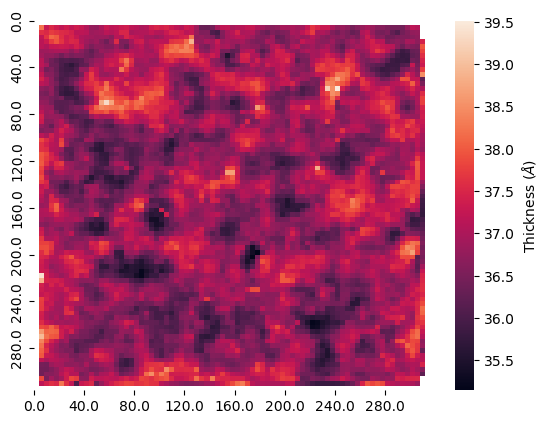

In [39]:
ax = sns.heatmap(
    thickness.results.mean_interpolated[0],
    cbar_kws={"label": "Thickness ($\AA$)"}
)
n_tick_step = 10
ax.set_xticks(
    np.arange(0, thickness.n_x, n_tick_step),
    thickness.x_axis[::n_tick_step],
    rotation=0
)
ax.set_yticks(
    np.arange(0, thickness.n_y, n_tick_step),
    thickness.y_axis[::n_tick_step],
);

## Curvature

This class calculates the min, max, mean, and Gaussian curvatures. For an introduction please see other resources such as https://en.wikipedia.org/wiki/Principal_curvature or the specific membrane-curvature MDAKit https://membrane-curvature.readthedocs.io/en/latest/source/pages/Algorithm.html

As with MembraneThickness, this subclasses `GriddedBilayerAnalysisBase` and is operated on a grid.

Unfortunately I have been bad at consistent naming so the properties of interest here are:

* average_mean
* average_gaussian
* average_min
* average_max

Each of these are arrays of shape (`n_bilayer`, `n_x_axis`, `n_y_axis`).

In [40]:
from lipyds.analysis.curvature import Curvature

In [41]:
curvature = Curvature(
    universe=membrane_residues,
    select="name PO4 GL1 GL2 AM1 AM2 NC3 GM* C3",
    leafletfinder=finder,
    bin_size=2,  # each box covers 2x2 A
)

In [42]:
curvature.run(verbose=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [43]:
curvature.results.average_mean.shape

(1, 156, 156)

You could calculate a mean quantity like below, although **this is unlikely to be meaningful in anyway for properties like membrane curvature.**

In [44]:
curvature.results.average_mean.mean()

1.8848413457488654e-05

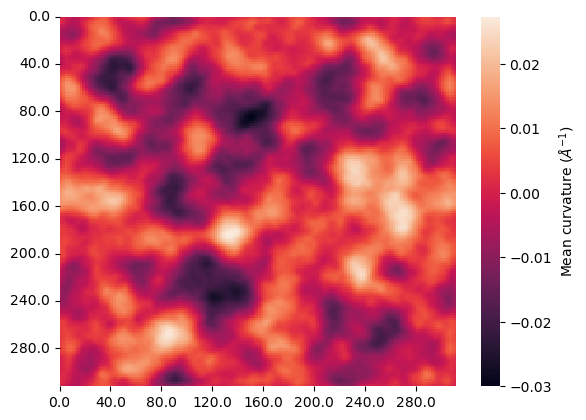

In [45]:
ax = sns.heatmap(
    curvature.results.average_mean[0],
    cbar_kws={"label": "Mean curvature ($\AA^{-1}$)"}
)
n_tick_step = 20
ax.set_xticks(
    np.arange(0, curvature.n_x, n_tick_step),
    curvature.x_axis[::n_tick_step],
    rotation=0
)
ax.set_yticks(
    np.arange(0, curvature.n_y, n_tick_step),
    curvature.y_axis[::n_tick_step],
);

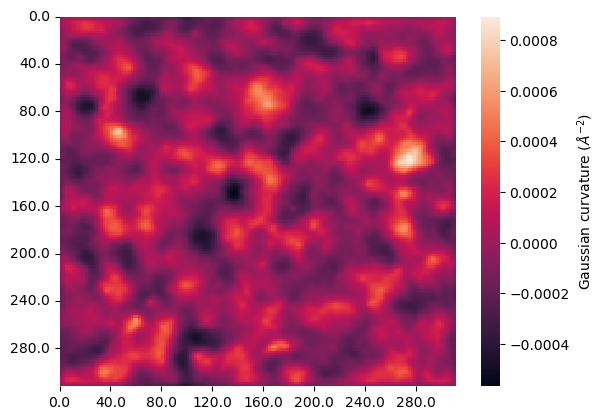

In [46]:
ax = sns.heatmap(
    curvature.results.average_gaussian[0],
    # **note different units to mean curvature!!**
    cbar_kws={"label": "Gaussian curvature ($\AA^{-2}$)"}
)
n_tick_step = 20
ax.set_xticks(
    np.arange(0, curvature.n_x, n_tick_step),
    curvature.x_axis[::n_tick_step],
    rotation=0
)
ax.set_yticks(
    np.arange(0, curvature.n_y, n_tick_step),
    curvature.y_axis[::n_tick_step],
);

## Tilt

This calculates the angle between the `select` beads and `select_end` beads to the specified `normal`. If `bilayer`, the bilayer normal is used. Unlike some other analyses, it is not the single residue point normal that is used as the normal vector. Instead, the point normals of all neighbours within `cutoff` A are averaged together to create the reference angle. I believe this to be more robust than just using a single point value. 

In [47]:
from lipyds.analysis.tilt import LipidTilt

In [48]:
u.select_atoms("resname CLRO").residues[0].atoms.names

array(['ROH', 'R1', 'R2', 'R3', 'R4', 'R5', 'C1', 'C2'], dtype=object)

In [49]:
chol = u.select_atoms("resname CHOL OCLR CLRO")
heads = "name ROH"
tails = "name C2"

tilt = LipidTilt(
    universe=chol,
    leafletfinder=finder,
    select=heads,
    select_end=tails,
    cutoff=10,
    normal="bilayer",  # or -- "x", "y", "z"
)

In [50]:
tilt.run(verbose=True)

  0%|          | 0/17 [00:00<?, ?it/s]

/Users/lily/pydev/lipyds/lipyds/analysis/base.py:29: RuntimeWarning: Mean of empty slice
  values = np.nanmean(by_leaflet, axis=0)


In [51]:
list(tilt.results.keys())

['cosine_similarity_by_leaflet',
 'tilts_by_leaflet',
 'acute_tilts_by_leaflet',
 'tilts',
 'tilts_by_attr',
 'acute_tilts',
 'acute_tilts_by_attr']

In [52]:
df = tilt.results_as_dataframe()
df

,Leaflet,Value,Time,Label,Property
0,1,156.370397,0.0,CHOL,tilts
1,1,169.088999,5000000.0,CHOL,tilts
2,1,163.177223,6250000.0,CHOL,tilts
3,1,143.600563,7500000.0,CHOL,tilts
4,1,171.899885,10000000.0,CHOL,tilts
...,...,...,...,...,...
44351,2,29.897225,0.0,CLRO,acute_tilts
44352,2,11.686294,1250000.0,CLRO,acute_tilts
44353,2,52.653122,6250000.0,CLRO,acute_tilts
44354,2,18.266159,12500000.0,CLRO,acute_tilts


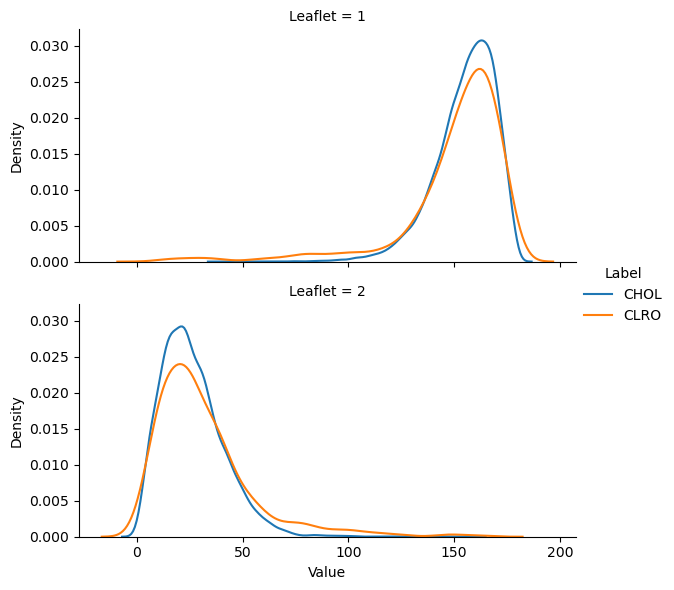

In [53]:
g = sns.FacetGrid(
    data=df[df.Property == "tilts"],
    row="Leaflet",
    hue="Label",
    aspect=2,
)
g.map(sns.kdeplot, "Value")
g.add_legend()

## Flip Flop

Out of all analyses here this is the least developed -- e.g. it does not have a `summary_as_dataframe` method. Instead it just outputs a dictionary of events, or you can check the raw data yourself. 

For each cholesterol we select all neighbours within `cutoff` radius, in each leaflet. We calculate the distance between the cholesterol bead and each of these neighbours. We select the minimum distance. If this minimum distance is less than `leaflet_width`, the cholesterol is considered to be part of the leaflet containing the neighbour.

A molecule can be in the upper leaflet, lower leaflet, or interstitial space. A translocation event only covers events from leaflet to leaflet. 

In [54]:
from lipyds.analysis.flipflop import LipidFlipFlop

In [55]:
chol = u.select_atoms("resname CHOL OCLR CLRO")

In [56]:
chol.residues[0].atoms.names

array(['ROH', 'R1', 'R2', 'R3', 'R4', 'R5', 'C1', 'C2'], dtype=object)

In [57]:
flipflop = LipidFlipFlop(
    universe=chol,
    leafletfinder=finder,
    select="name R2", # to pick something closer to the middle
    leaflet_width=8,  # within this distance, a bead is considered to be part of that leaflet
    cutoff=5, # cutoff radius (A) to select neighbours in leaflets to calculate distances
)

In [58]:
flipflop.run(verbose=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [59]:
flipflop.results.flipflop_leaflet.shape  # (n_frames, n_residues)

(17, 1798)

Residues assigned to 0 are in the upper leaflet, to 1 is the lower leaflet, to -1 is neither (either interstitial space or kicked out from bilayer).

You can inspect the assigned leaflets below:

In [60]:
flipflop.results.flipflop_leaflet

array([[ 0,  0,  0, ..., -1, -1,  1],
       [ 1,  1,  0, ..., -1,  1,  1],
       [ 1,  1,  1, ..., -1, -1,  0],
       ...,
       [ 1,  0,  0, ..., -1,  1, -1],
       [ 0,  0,  0, ..., -1,  1, -1],
       [ 0,  0, -1, ..., -1, -1, -1]])

I recommend choosing a residue (e.g. the first one) and visually inspecting some frames if you are uncertain about the results.

In [61]:
flipflop.results.flipflop_leaflet[:, 0]

array([ 0,  1,  1,  1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  1,  0,  0])

This VMD selection keyword would be "resid 1 and name ROH".

In [62]:
flipflop.selection.residues[0].resid

1

In [63]:
flipflop.lower_i  # index of lower leaflet -- this is a class attribute if you want to check again
# flipflop.upper_i
# flipflop.inter_i

1

In [64]:
flipflop.results.flips_by_attr

{'CHOL': 4326, 'CLRO': 639}

In [65]:
flipflop.results.flops_by_attr

{'CHOL': 4369, 'CLRO': 634}